<a href="https://colab.research.google.com/github/cswcjt/Dacon_Bike/blob/main/TFT_first.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture 
!pip install torch pytorch-lightning pytorch_forecasting

In [4]:
import warnings
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
#from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [5]:
import itertools
import os
import holidays

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Extented Time-Series Format

In [6]:
base_path = "/content/drive/MyDrive/fastcamp/datas/bike/"
train = pd.read_csv(base_path + "train.csv")
submission = pd.read_csv(base_path + "sample_submission.csv")
save_path = "/content/drive/MyDrive/fastcamp/datas/"

In [7]:
train

,일시,광진구,동대문구,성동구,중랑구
0,20180101,0.592,0.368,0.580,0.162
1,20180102,0.840,0.614,1.034,0.260
2,20180103,0.828,0.576,0.952,0.288
3,20180104,0.792,0.542,0.914,0.292
4,20180105,0.818,0.602,0.994,0.308
...,...,...,...,...,...
1456,20211227,3.830,3.416,2.908,2.350
1457,20211228,4.510,3.890,3.714,2.700
1458,20211229,4.490,3.524,3.660,2.524
1459,20211230,4.444,3.574,3.530,2.506


In [8]:
train['일시'] = pd.to_datetime(train['일시'], format='%Y%m%d')
train = train.set_index(keys=['일시'], drop=True)
train = train.rename(columns={"광진구": "g", "동대문구": "d", "성동구": "s", "중랑구": "j"})
train

,g,d,s,j
일시,,,,
2018-01-01,0.592,0.368,0.580,0.162
2018-01-02,0.840,0.614,1.034,0.260
2018-01-03,0.828,0.576,0.952,0.288
2018-01-04,0.792,0.542,0.914,0.292
2018-01-05,0.818,0.602,0.994,0.308
...,...,...,...,...
2021-12-27,3.830,3.416,2.908,2.350
2021-12-28,4.510,3.890,3.714,2.700
2021-12-29,4.490,3.524,3.660,2.524


In [9]:
# 데이터의 시작 시점을 기억
earliest_time = train.index.min() 
earliest_time

Timestamp('2018-01-01 00:00:00')

In [10]:
df_list = []

for region in train:
    # label = region
    ts = train[region]
    # display(ts)
    
    # tmp 생성
    # date도 생성 -> month, day, hour 등 시간에 관련 된 모든 데이터 갖고있다.
    tmp = pd.DataFrame({'usage': ts})
    date = tmp.index


    # 시간 변화 대한 정보들 컬럼들도 만들어 준다.  
    tmp['days_from_start'] = (date - earliest_time).days
    tmp['date'] = date

    # 시간 자체에 대한 정보들 컬럼들도 만들어 준다.  
    tmp['date'] = date
    tmp['day'] = date.day
    tmp['day_of_week'] = date.dayofweek
    tmp['month'] = date.month
    tmp['year'] = date.year

    # 고객정보 컬럼도 만들어준다. 
    tmp['region'] = region

    # stack all time series vertically
    df_list.append(tmp)

demand_df = pd.concat(df_list).reset_index(drop=True)
demand_df

,usage,days_from_start,date,day,day_of_week,month,year,region
0,0.592,0,2018-01-01,1,0,1,2018,g
1,0.840,1,2018-01-02,2,1,1,2018,g
2,0.828,2,2018-01-03,3,2,1,2018,g
3,0.792,3,2018-01-04,4,3,1,2018,g
4,0.818,4,2018-01-05,5,4,1,2018,g
...,...,...,...,...,...,...,...,...
5839,2.350,1456,2021-12-27,27,0,12,2021,j
5840,2.700,1457,2021-12-28,28,1,12,2021,j
5841,2.524,1458,2021-12-29,29,2,12,2021,j
5842,2.506,1459,2021-12-30,30,3,12,2021,j


In [11]:
1460 - 1096

364

In [12]:
demand_df.query("days_from_start==1096")

,usage,days_from_start,date,day,day_of_week,month,year,region
1096,2.070,1096,2021-01-01,1,4,1,2021,g
2557,1.650,1096,2021-01-01,1,4,1,2021,d
4018,1.676,1096,2021-01-01,1,4,1,2021,s
5479,1.222,1096,2021-01-01,1,4,1,2021,j


In [13]:
demand_df[['region','usage']].groupby('region').mean()

,usage
region,
d,4.233670
g,6.209194
j,3.138747
s,5.182951


In [14]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# #plt.rcParams.update(plt.rcParamsDefault)
# sns.set_style('darkgrid')
# sns.color_palette("tab10")

# fig, ax = plt.subplots(figsize=(13, 5))

# sns.lineplot(data=demand_df[demand_df['month'] == 1], 
#              x='date', 
#              y='usage', 
#              hue='region', 
#              legend='full',
#              palette='husl').set_title('usage per consumers')

# ax.set_xlabel("Date", fontdict={"color":  "black", "size": 13} )
# ax.set_ylabel("bike usage (thousand)", fontdict={"color":  "black", "size": 13})
# ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
# ax.set_title(label = "bike usage of each regions", fontdict={"color":  "black", "size": 15})

In [15]:
#Hyperparameters
#batch size=64
#number heads=4, hidden sizes=160, lr=0.001, gr_clip=0.1

# 1년 대한 전력 사용량 예측
max_prediction_length = 364

# 3년을 lookback window 로 설정: 3*364  
max_encoder_length = 1096

# train data 설정
training_cutoff = demand_df["days_from_start"].max() - max_prediction_length
training = TimeSeriesDataSet(
    # train dataframe 설정
    # idx 설정
    demand_df[lambda x: x.days_from_start <= training_cutoff],
    time_idx="days_from_start",

    # target 설정
    target="usage",

    # 그룹 설정
    group_ids=["region"],

    # encoder, prediciton
    min_encoder_length=max_encoder_length // 2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,

    # 각 컬럼이 어떤 유형의 변수인지 구분
    static_categoricals=["region"],
    time_varying_known_reals=["days_from_start","date","day","day_of_week", "month", "year"],
    time_varying_unknown_reals=['usage'],

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,

)

validation = TimeSeriesDataSet.from_dataset(training, demand_df, predict=True, stop_randomization=True)

# create dataloaders for  our model
batch_size = 64 
# if you have a strong GPU, feel free to increase the number of workers  
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [16]:
demand_df['region'].value_counts()

g    1461
d    1461
s    1461
j    1461
Name: region, dtype: int64

The **training.index** and **validation.index** show how our training and validation instances are sliced.   
For example, **sequence_length**= **max_encoder_length** + **max_prediction_length**

In [17]:
validation.index

,time_first,time_last,time_diff_to_next,index_start,time,count,sequence_id,index_end,sequence_length
1,0,1460,1,1,1,1461,0,1460,1460
1462,0,1460,1,1462,1,1461,1,2921,1460
2923,0,1460,1,2923,1,1461,2,4382,1460
4384,0,1460,1,4384,1,1461,3,5843,1460


### Baseline Model

In [18]:
# actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
# baseline_predictions = Baseline().predict(val_dataloader)
# (actuals - baseline_predictions).abs().mean().item()

### Build TFT model

In [19]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs")  

trainer = pl.Trainer(
    max_epochs=2,
    accelerator='gpu', 
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10, 
    reduce_on_plateau_patience=4,
)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICE

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Standa

Training: 0it [00:00, ?it/s]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not 

Validation: 0it [00:00, ?it/s]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not 

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Standa

In [20]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs/lightning_logs/version_0/checkpoints/epoch=1-step=136.ckpt


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


### out of sample prediction
    - max_prediction_length = 334 --> Jan to Nov, excepting Dec
    - max_encoder_length = 365

In [126]:
max_prediction_length = 334

In [137]:
max_encoder_length = 365*2

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


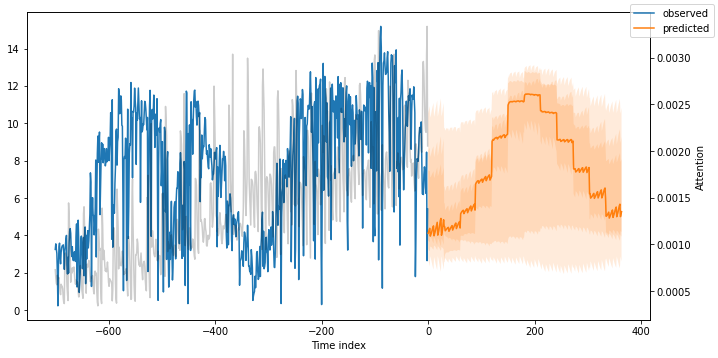

In [148]:
from pandas.tseries.offsets import DateOffset

#encoder data is the last lookback window: we get the last 1 year 365 for all 4 regions =  total 365*4 datapoints
encoder_data = demand_df[lambda x: x.days_from_start > x.days_from_start.max() - max_encoder_length]
last_data = demand_df[lambda x: x.days_from_start == x.days_from_start.max()]
#display(encoder_data)
#display(last_data)

# decoder_data is the new dataframe for which we will create predictions. 
# decoder_data df should be max_prediction_length*region: 334*4=1336 datapoints long: 1336 datapoints for each cosnumer
# we create it by repeating the last 3*365 observation of every region 334 times since we do not really have new test data
# and later we fix the columns
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.Timedelta(days=i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

#fix the new columns
decoder_data["days_from_start"] = (decoder_data["date"] - earliest_time).dt.days
decoder_data['days_from_start'] = decoder_data['days_from_start'].astype('int')
decoder_data["days_from_start"] += encoder_data["days_from_start"].max() + 1 - decoder_data["days_from_start"].min()

decoder_data["year"] = decoder_data["date"].dt.year.astype(np.int64)
decoder_data["month"] = decoder_data["date"].dt.month.astype(np.int64)
decoder_data["day"] = decoder_data["date"].dt.day.astype(np.int64)
decoder_data["day_of_week"] = decoder_data["date"].dt.dayofweek.astype(np.int64)
#display(decoder_data)

new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
fig, ax = plt.subplots(figsize=(10, 5))

new_prediction_data=new_prediction_data.query("region == 'g'")
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)
best_tft.plot_prediction(new_x, new_raw_predictions, idx=0, show_future_observed=False, ax=ax);

In [123]:
# # Start tensorboard
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs

In [124]:
# actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
# predictions = best_tft.predict(val_dataloader)

# #average p50 loss overall
# print((actuals - predictions).abs().mean().item())
# #average p50 loss per time series
# print((actuals - predictions).abs().mean(axis=1))

In [125]:
# raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

# for idx in range(4):  # plot all 4 regions
#     fig, ax = plt.subplots(figsize=(10, 4))
#     best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True,ax=ax)

In [141]:
len(new_raw_predictions)

8